# Solve Max-Cut using Fire Opal
**Solve weighted and unweighted Max-Cut instances using Fire Opal's built-in QAOA solver**

The Max-Cut problem is a classic problem in combinatorial optimization and graph theory. It involves partitioning the vertices of a graph into two distinct subsets such that the number of edges between the two subsets is maximized. The Max-Cut problem can be applied to many real-world applications across various domains, such as communications network design, image segmentation in computer vision, and financial risk management.

[Fire Opal's built-in Quantum Approximate Optimization Algorithm (QAOA) solver](https://docs.q-ctrl.com/fire-opal/topics/fire-opals-qaoa-solver) can deliver solutions to nontrivial unweighted and weighted graph Max-Cut problems instances using quantum hardware.

In a recent paper, [Q-CTRL published results](https://arxiv.org/abs/2406.01743) benchmarking Fire Opal's QAOA Solver on several classically nontrivial unconstrained binary optimization problems and demonstrated the ability to correctly solve Max-Cut instances that represent the largest quantum optimizations successfully performed on hardware to date.

This application note provides the following information and example to produce results on an even larger graph problem than those shown in the published manuscript:

- Defining the Max-Cut problem
- Introducing QAOA
- Solving a 156-node, 3-regular unweighted graph Max-Cut problem with Fire Opal

## 1. Introduction

### 1.1 Defining the Max-Cut problem

The aim of Max-Cut is to separate the nodes of a graph into two groups by intersecting as many edges between nodes as possible with a single partition, or "cut".
For non-planar graphs, those with edges that cross one another, it has been mathematically proven that a polynomial-time solution does not exist, making this problem an excellent candidate for approximate optimization.

Quantum optimization algorithms are an attractive near-term opportunity to deliver efficient solutions to key high-impact applications that are classically nontrivial.

### 1.2 Introducing QAOA

QAOA is an algorithm often applied to combinatorial optimization problems, which involve finding an optimal object out of a finite set of objects. Such problems are relevant in many fields, such as portfolio optimization, supply chain optimization, optimal networking and scheduling, transportation routing, and more. Many combinatorial optimizations of interest fall under the NP-hard complexity class, meaning that there are no known polynomial-time solutions.

QAOA is one algorithm within the broader class of variational quantum algorithms (VQAs), which use classical optimization techniques to train a parameterized quantum circuit. Combining the power of both classical and quantum computation, VQAs are a promising method to achieve quantum advantage on NISQ devices and will likely remain relevant even in the age of fault-tolerant quantum computing.

Typically when implementing the QAOA, one must:
- Define cost and mixer Hamiltonians
- Construct circuits for the cost and mixer layers
- Choose parameters
- Prepare the initial state
- Implement a classical parameter optimizer

Adding to the challenge, most implementations of QAOA fail when executed on real hardware, either converging on the wrong solution or never converging at all.

Fire Opal’s QAOA solver alleviates the complexity of running QAOA algorithms by providing an easy-to-use function that consistently returns the correct answer. It converges quickly and enables the full QAOA implementation on problem sizes [greater than achievable with other commercial QAOA methods](https://arxiv.org/abs/2406.01743).

## 2. Imports and initialization

The following section sets up the necessary imports and helper functions. You can install the required packages by uncommenting the following cell if you are running this example in a notebook using the IPython kernel.

In [4]:
import fireopal as fo
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from pyscipopt import Model
from sympy import symbols, Poly
import qctrlvisualizer as qv

### 2.1 Set up your account and choose a backend
To run this tutorial, you will need an [IBM Quantum account](https://quantum.ibm.com/). Set up your IBM account information to choose a backend.

In [5]:
# These are the properties for the publicly available provider for IBM backends.
# If you have access to a private provider and wish to use it, replace these values.
hub = "ibm-q"
group = "open"
project = "main"
token = "d15cd0d8016389774102566f7b8f173547f859dd1ac3cb13f19dd0c07f5f058fc55f3358b470e1b8c3ed03ec05250c36f293a2f8142bf6272afeabf638bb9db3"
credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

In [6]:
# Enter your desired IBM backend here.
backend_name = "ibm_brisbane"

### 2.2 Define helper functions
The following functions are used to set up the Max-Cut problem instances and analyze results.

In [7]:
def maxcut_obj(bitstring: str, graph: nx.Graph) -> float:
    """
    Given a bitstring, this function returns the number of edges
    shared between the two partitions of the graph.
    """
    obj = 0
    # Iterate through each edge in the graph
    for i, j, data in graph.edges(data=True):
        # Calculate the contribution of the edge to the Max-Cut objective
        # If the nodes are in different partitions, the term (int(bitstring[i]) - int(bitstring[j]))**2 will be 1
        # Otherwise, it will be 0
        obj -= data.get("weight", 1) * (int(bitstring[i]) - int(bitstring[j])) ** 2
    return obj


def get_cost_distribution(
    distribution: dict[str, int], graph: nx.Graph
) -> tuple[np.ndarray, np.ndarray]:
    """
    Given a bitstring count distribution and a graph, returns the
    costs and relative probabilities as numpy arrays.
    """
    # Total number of bitstrings (shots)
    shot_count = sum(distribution.values())
    costs = []
    probabilities = []
    # Calculate the cost and probability for each bitstring
    for bitstring, count in distribution.items():
        # Reverse the bitstring to match graph node indices
        cost = maxcut_obj(bitstring[::-1], graph)
        costs.append(cost)
        probabilities.append(count / shot_count)
    return np.array(costs), np.array(probabilities)


def generate_random_bitstrings(length, num_bitstrings, rng_seed=0) -> list[str]:
    """
    Generate a random sampling of bitstrings.
    """
    # Initialize the random number generator with a seed for reproducibility
    rng = np.random.default_rng(seed=rng_seed)
    # Generate random bitstrings
    random_array = rng.integers(0, 2, size=(num_bitstrings, length))
    bitstrings = ["".join(row.astype(str)) for row in random_array]
    return bitstrings


def calculate_percent_gap_to_optimal(
    costs: np.ndarray, optimal_cut_value: float
) -> None:
    """
    Determine the percent gap between the optimal cut value and the best cut value
    found from Fire Opal.
    """
    # Find the best cut value found (most negative cost)
    best_cut_value_found = max(-costs)
    # Calculate the percentage difference from the optimal value
    percent_optimality = np.round(
        100 - (abs(optimal_cut_value - best_cut_value_found) / optimal_cut_value * 100),
        2,
    )
    # Print the results
    print(
        f"The best cut value found by Fire Opal is {best_cut_value_found}. \n"
        f"This solution is {percent_optimality}% optimized relative to the classically determined solution, {optimal_cut_value}."
    )


def analyze_maxcut_results(
    distribution: dict[str, int], graph: nx.Graph, optimal_cut_value: float
) -> None:
    """
    Analyze results from Max-Cut execution.
    """
    # Number of nodes in the graph
    qubit_count = graph.number_of_nodes()
    # Total number of bitstrings (shots)
    shot_count = sum(distribution.values())

    # Get cost distribution from the results
    costs, probs = get_cost_distribution(distribution, graph)
    # Generate random bitstrings and get their cost distribution
    random_bitstrings = generate_random_bitstrings(qubit_count, shot_count)
    random_probs = np.ones(shot_count) / shot_count
    random_costs = np.asarray(
        [maxcut_obj(bitstring[::-1], graph) for bitstring in random_bitstrings]
    )

    # Plot histograms of cut values
    plt.style.use(qv.get_qctrl_style())
    fig, ax = plt.subplots(1, 1)

    n, bin_edges, _ = ax.hist(
        [-costs, -random_costs],
        np.arange(-max(random_costs), -min(costs) + 1, 1),
        weights=[probs, random_probs],
        label=["Fire Opal QAOA solver", "Random Sampling"],
        color=[qv.QCTRL_STYLE_COLORS[0], qv.QCTRL_STYLE_COLORS[1]],
    )
    ax.set_xlabel("Cut Value")
    ax.set_ylabel("Probability")
    ax.legend()

    # Calculate and print the percent gap to optimal
    calculate_percent_gap_to_optimal(costs=costs, optimal_cut_value=optimal_cut_value)


def solve_maxcut_classically(graph):
    """
    Solve the Max-Cut problem classically using linear programming.
    """
    model = Model("MaxCut")
    # Add binary variables for edges
    e = {(u, v): model.addVar(vtype="B", name=f"e({u, v})") for u, v in graph.edges()}
    # Add binary variables for nodes
    x = {u: model.addVar(vtype="B", name=f"x({u})") for u in graph.nodes()}

    # Define the objective function to maximize the cut value
    objective = sum(
        data.get("weight", 1) * e[(u, v)] for u, v, data in graph.edges(data=True)
    )
    model.setObjective(objective, "maximize")

    # Add constraints to ensure valid cuts
    for u, v in graph.edges():
        model.addCons(e[(u, v)] <= x[u] + x[v])
        model.addCons(e[(u, v)] <= 2 - (x[u] + x[v]))

    model.hideOutput(True)
    model.optimize()

    # Ensure the solution is optimal
    assert model.getStatus() == "optimal"

    # Return the solution indicating which partition each node belongs to
    return {u: model.getVal(x[u]) for u in graph.nodes()}


def cut_value(graph, cut):
    """
    Calculate the cut value of a given partition.
    """
    value = 0
    # Calculate the total weight of the cut edges
    for i, j, data in graph.edges(data=True):
        value += data.get("weight", 1) * np.round(cut[i] - cut[j]) ** 2
    return value

## Example: Unconstrained Optimization
Run the [maximum cut](https://en.wikipedia.org/wiki/Maximum_cut) (Max-Cut) problem. The following example demonstrates the Solver's capabilities on a 156-node, 3-regular unweighted graph Max-Cut problem, but you can also solve weighted graph problems.

### 1. Define the problem
You can run a Max-Cut problem by defining a graph problem and specifying `problem_type='maxcut'`.

In [28]:
import networkx as nx
import numpy as np

# Generate a random graph with 156 nodes
unweighted_graph = nx.random_regular_graph(d=3, n=126, seed=8)

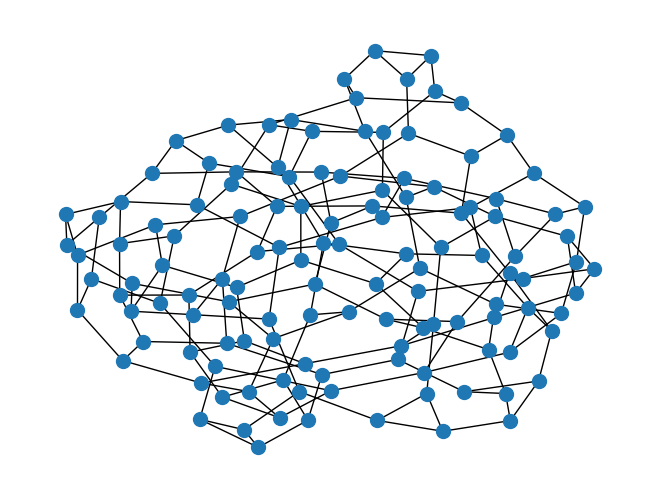

In [29]:
# Optionally, visualize the graph
nx.draw(unweighted_graph, nx.kamada_kawai_layout(unweighted_graph), node_size=100)

### 2. Solve the graph problem using Fire Opal's QAOA Solver

In [10]:
unweighted_job = fo.solve_qaoa(
    problem=unweighted_graph,
    credentials=credentials,
    problem_type="maxcut",
    backend_name=backend_name,
)

This function performs multiple consecutive runs. Wait time may vary depending on hardware queues.



In [ ]:
unweighted_result = unweighted_job.result()

In [26]:
unweighted_result = fo.get_result(2058729)

/pscratch/sd/g/gzquse/cudaq/lib/python3.10/site-packages/qctrlworkflowclient/functions.py:155: RuntimeWarning: After optimized compilation, the QAOA circuit is reaching hardware T1 time limitations. To improve performance, try to reduce the number of multi-qubit terms in the cost function.
  warn(warning, RuntimeWarning)
/pscratch/sd/g/gzquse/cudaq/lib/python3.10/site-packages/qctrlworkflowclient/functions.py:155: RuntimeWarning: The X gate error is much higher than the median right now. This will negatively impact Q-CTRL's performance. For better results, try running on a different device. Visit https://quantum-computing.ibm.com/services/resources?tab=systems&system=ibm_brisbane for information on device error rates.
  warn(warning, RuntimeWarning)
/pscratch/sd/g/gzquse/cudaq/lib/python3.10/site-packages/qctrlworkflowclient/functions.py:155: RuntimeWarning: The measurement error is much higher than the median right now. This will negatively impact Q-CTRL's performance. For better resu

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='d15cd0d8016389774102566f7b8f173547f859dd1ac3cb13f19dd0c07f5f058fc55f3358b470e1b8c3ed03ec05250c36f293a2f8142bf6272afeabf638bb9db3'
)
job = service.job('cxd03bdtpsjg0083m380')
unweighted_result = job.result()

# To get counts for a particular pub result, use 
#
# pub_result = job_result[<idx>].data.<classical register>.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

### 3. Solve the graph problem using classical methods
Because this problem is still within the bounds of what can be solved by classical methods, it's possible to check the accuracy of Fire Opal's obtained solution.

In [21]:
unweighted_result[0].data

DataBin(meas=BitArray(<shape=(), num_shots=8192, num_bits=126>))

In [31]:
solution = solve_maxcut_classically(unweighted_graph)
optimal_cut_value = cut_value(unweighted_graph, solution)
print(f"Classically derived cut value: {optimal_cut_value}")

Classically derived cut value: 172.0


### 4. Plot and analyze the solutions generated by Fire Opal
The performance baseline is set by sampling bitstrings uniformly at random (red histogram bars), akin to a random brute-force scan through the solution set. In all cases, the number of samples is taken to be the same as the samples of the optimal QAOA circuit. This baseline is chosen because a naive QAOA implementation using standard Qiskit compilers returns results indistinguishable from random selection when solving problems at this scale.

In [25]:
from fireopal import activity_monitor
activity_monitor(limit=10, status="SUCCESS")

| Function               | Status  | Created at (UTC)    | Updated at (UTC)    | Action ID |
| ---------------------- | ------- | ------------------- | ------------------- | --------- |
| solve_qaoa             | SUCCESS | 2024-12-11 20:56:33 | 2024-12-11 21:19:32 | 2058729   |
| validate               | SUCCESS | 2024-12-04 18:14:34 | 2024-12-04 18:14:43 | 2056623   |
| show_supported_devices | SUCCESS | 2024-12-04 18:14:25 | 2024-12-04 18:14:33 | 2056622   |
| execute                | SUCCESS | 2024-12-03 17:45:29 | 2024-12-03 21:04:46 | 2056526   |
| validate               | SUCCESS | 2024-12-03 17:45:11 | 2024-12-03 17:45:24 | 2056525   |
| show_supported_devices | SUCCESS | 2024-12-03 17:44:29 | 2024-12-03 17:44:38 | 2056524   |


The best cut value found by Fire Opal is 171. 
This solution is 81.43% optimized relative to the classically determined solution, 210.0.


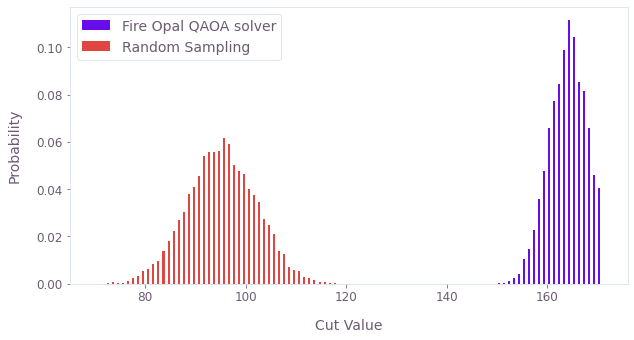

In [30]:
analyze_maxcut_results(
    distribution=unweighted_result["final_bitstring_distribution"],
    graph=unweighted_graph,
    optimal_cut_value=optimal_cut_value,
)

In this scenario, the solutions produced by Fire Opal's QAOA solver significantly outperform the cut values obtained via random sampling, a benchmark akin to naive QAOA implementations at this scale. Fire Opal's best cut value closely approximates the true optimal solution.

Congratulations on successfully leveraging Fire Opal's QAOA Solver to solve a challenging Max-Cut problem with quantum hardware. For a deeper dive into what sets Fire Opal's QAOA Solver apart and its efficacy in finding accurate solutions at utility scales, explore the topic on [Fire Opal's QAOA Solver](https://docs.q-ctrl.com/fire-opal/topics/fire-opals-qaoa-solver).

The following package versions were used to produce this notebook.

In [11]:
from fireopal import print_package_versions

print_package_versions()

| Package               | Version |
| --------------------- | ------- |
| Python                | 3.11.8  |
| matplotlib            | 3.9.2   |
| networkx              | 2.8.8   |
| numpy                 | 1.26.4  |
| sympy                 | 1.13.3  |
| fire-opal             | 8.1.2   |
| qctrl-visualizer      | 8.0.2   |
| qctrl-workflow-client | 5.0.1   |


In [1]:
# Import necessary libraries
import networkx as nx
import numpy as np
from fireopal import solve_maxcut_problem, analyze_maxcut_results

# Function to assign priorities based on bitstring coefficients
def calculate_priorities_from_coefficients(bitstring_distribution):
    priorities = {}
    total_amplitude = sum(bitstring_distribution.values())
    
    for bitstring, amplitude in bitstring_distribution.items():
        coefficient = amplitude / total_amplitude
        priorities[bitstring] = coefficient

    return priorities

# Create a sample graph for Max-Cut problem
graph = nx.Graph()
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])

# Solve the Max-Cut problem using Fire Opal
result = solve_maxcut_problem(graph)

# Extract bitstring distribution from results
bitstring_distribution = result["final_bitstring_distribution"]

# Calculate edge priorities based on coefficients
edge_priorities = calculate_priorities_from_coefficients(bitstring_distribution)

# Print calculated priorities
print("Edge Priorities based on bitstring coefficients:")
for edge, priority in edge_priorities.items():
    print(f"Edge {edge}: Priority {priority}")

# Analyze and visualize results
analyze_maxcut_results(
    distribution=bitstring_distribution,
    graph=graph,
    optimal_cut_value=None  # Replace with known optimal value if available
)


ImportError: cannot import name 'solve_maxcut_problem' from 'fireopal' (/pscratch/sd/g/gzquse/cudaq/lib/python3.10/site-packages/fireopal/__init__.py)